<a href="https://colab.research.google.com/github/mikethisyamondol/disaster_tweets/blob/main/nlp_with_disaster_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing with Disaster Tweets

Mike Thisyamondol

### Ingest

In [2]:
from IPython.display import clear_output
!pip install tokenizers
!pip install transformers
!pip install tensorflow_hub
!pip install tensorflow_text
clear_output()

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import zipfile
import seaborn as sns
from IPython import display
import pickle
import datetime
import os
import random
from shutil import copyfile
from random import seed
from tqdm import tqdm

import nltk
nltk.download('all')
import re
import string
import lxml.html.clean
import lxml.html
from nltk.tokenize import RegexpTokenizer, word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils import shuffle
import gensim
from gensim.models.word2vec import Word2Vec
LabeledSentence = gensim.models.doc2vec.LabeledSentence

from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Flatten, GlobalMaxPool1D, GRU
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Dropout, Input, SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel, BertConfig
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.layers import BatchNormalization


%matplotlib inline
clear_output()

In [4]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Hqs_GVKEqC24F_Ieth0wlV7DM6BTmUS0' -O kaggle.json.zip

clear_output()

In [5]:
with zipfile.ZipFile('kaggle.json.zip', 'r') as zip_ref:
    zip_ref.extractall('kaggle.json')

In [6]:
! pip install kaggle

clear_output()

In [7]:
! mkdir ~/.kaggle

In [8]:
! cp ./kaggle.json/kaggle.json ~/.kaggle/

In [9]:
! chmod 600 ~/.kaggle/kaggle.json

In [10]:
! kaggle competitions download -c nlp-getting-started

clear_output()

In [11]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')

In [12]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Data Prep

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [14]:
df_train['target'].value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

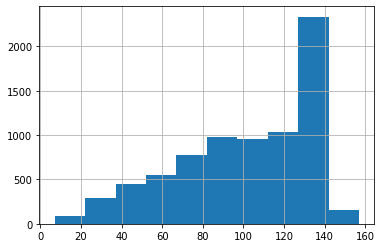

In [15]:
char_lens = df_train['text'].str.len()
char_lens.hist()

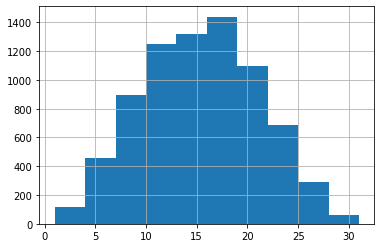

In [16]:
word_lens = df_train['text'].str.split().str.len()
word_lens.hist()

Clean

In [17]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                       u"\U0001F600-\U0001F64F"
                       u"\U0001F300-\U0001F5FF"
                       u"\U0001F680-\U0001F6FF"
                       u"\U0001F1E0-\U0001F1FF"
                       u"\U00002702-\U000027B0"
		                   u"\U000024C2-\U0001F251"
		                   u"\U0001f926-\U0001f937"
		                   u'\U00010000-\U0010ffff'
		                   u"\u200d"
		                   u"\u2640-\u2642"
		                   u"\u2600-\u2B55"
		                   u"\u23cf"
		                   u"\u23e9"
		                   u"\u231a"
		                   u"\u3030"
		                   u"\ufe0f"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r' ', string)

In [18]:
# def preprocess(df):
#   # Correct HTML encodings
#   html_cleaner = lxml.html.clean.Cleaner(style=True)
#   df['text'] = df['text'].map(lambda x: html_cleaner.clean_html(lxml.html.fromstring(x)).text_content())
#   # Remove Emojis
#   df['text'] = df['text'].map(lambda x: remove_emoji(x))
#   # Remove line breaks etc.
#   df['text'] = df['text'].map(lambda x: re.sub(r'\n|\r', '', x))
#   # Remove URLs
#   df['text'] = df['text'].map(lambda x: re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', x, flags=re.MULTILINE))
#   # Remove Punctuation
#   df['text'] = df['text'].map(lambda x: re.sub(r'[^\w\s]','',x))
#   # Lowercase
#   df['text'] = df['text'].map(lambda x: x.lower())
#   # Remove records where clean_tweet is null or empty strings
#   df = df.dropna(subset=['text'])
#   df = df[(df['text'] != '') & (df['text'] != ' ')].reset_index().drop("index", axis=1)
#   # Stop words
#   text_with_no_stop_word = [w.lower() for w in clean_text if not w in stop_words]  
  
#   return df


In [19]:
def process(text):
  # Correct HMTML encodings
  html_cleaner = lxml.html.clean.Cleaner(style=True)
  text = html_cleaner.clean_html(lxml.html.fromstring(text)).text_content()
  # Remove emojis
  text = remove_emoji(text)
  # Remove line breaks etc.
  text = re.sub(r'\n|\r', '', text)
  # Remove URLs
  text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text, flags=re.MULTILINE)
  # Remove puncutation
  text = re.sub(r'[^\w\s]','', text)
  # Lowercase
  text = text.lower()
  # Lemmatize
  lemmatizer = WordNetLemmatizer()
  text = ' '.join([lemmatizer.lemmatize(w) for w in text.split()])
  # Remove stopwords
  stop_words = set(stopwords.words('english'))
  text = [x for x in text.split() if not x in stop_words]  


  return " ".join(" ".join(text).split())

In [20]:
df_train['clean_text'] = df_train['text'].apply(lambda x: process(x))
df_test['clean_text'] = df_test['text'].apply(lambda x: process(x))

In [21]:
df_train.head(10)

,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resident asked shelter place notified officer ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation order...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfire pour...
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,rockyfire update california hwy 20 closed dire...
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1,flood disaster heavy rain cause flash flooding...
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1,im top hill see fire wood
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1,emergency evacuation happening building across...
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1,im afraid tornado coming area


In [22]:
x_train, x_test, y_train, y_test = train_test_split(df_train['clean_text'],
                                                                   df_train['target'],
                                                                   test_size=0.2,
                                                                   random_state=0, 
                                                                   shuffle=True)


In [23]:
embedding_dim = 300
learning_rate = 1e-3
batch_size = 1024
epochs = 20
sequence_len = 100

In [24]:
y_train_LSTM = y_train.values.reshape(-1,1)
y_test_LSTM = y_test.values.reshape(-1,1)

print("Training Y shape:", y_train_LSTM.shape)
print("Testing Y shape:", y_test_LSTM.shape)


Training Y shape: (6090, 1)
Testing Y shape: (1523, 1)


In [25]:
# Tokenize train data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("Vocabulary Size: ", vocab_size)

Vocabulary Size:  14708


In [26]:
# Pad train and test 
x_train = pad_sequences(tokenizer.texts_to_sequences(x_train), maxlen=sequence_len)
x_test = pad_sequences(tokenizer.texts_to_sequences(x_test), maxlen=sequence_len)

print("Training X shape: ", x_train.shape)
print("Testing X shape: ", x_test.shape)

Training X shape:  (6090, 100)
Testing X shape:  (1523, 100)


GloVe Embeddings

In [27]:
path = './drive/MyDrive/Colab Notebooks/MSDS422/'
filename = 'glove.6B.300d.txt'

# read in embedding
embeddings_index = {}
with open(path+filename) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs


print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [28]:
# Define embedding layer in Keras
vocab_size = len(embeddings_index)

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            embedding_dim,
                                            weights=[embedding_matrix],
                                            input_length=sequence_len,
                                            trainable=False)

### Modeling

##### Model 1 - GloVe Embedding Bidirectional LSTM

In [29]:
sequence_input = Input(shape=(sequence_len, ), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)

x = Conv1D(128, 5, activation='relu')(embedding_sequences)
x = Bidirectional(LSTM(128, dropout=0.5, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(sequence_input, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 300)          120000000 
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           192128    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense (Dense)               (None, 512)               131584    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             

In [30]:
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['acc'])

In [31]:
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs, 
                    validation_data=(x_test, y_test))

Epoch 1/20
6/6 [==============================] - 67s 9s/step - loss: 0.6618 - acc: 0.5956 - val_loss: 0.5450 - val_acc: 0.7426
Epoch 2/20
6/6 [==============================] - 51s 9s/step - loss: 0.5378 - acc: 0.7660 - val_loss: 0.5002 - val_acc: 0.7682
Epoch 3/20
6/6 [==============================] - 52s 9s/step - loss: 0.4704 - acc: 0.7913 - val_loss: 0.4680 - val_acc: 0.7899
Epoch 4/20
6/6 [==============================] - 51s 9s/step - loss: 0.4432 - acc: 0.8080 - val_loss: 0.4782 - val_acc: 0.7905
Epoch 5/20
6/6 [==============================] - 78s 14s/step - loss: 0.4155 - acc: 0.8215 - val_loss: 0.4636 - val_acc: 0.7859
Epoch 6/20
6/6 [==============================] - 55s 9s/step - loss: 0.3966 - acc: 0.8309 - val_loss: 0.4578 - val_acc: 0.7951
Epoch 7/20
6/6 [==============================] - 63s 10s/step - loss: 0.3726 - acc: 0.8425 - val_loss: 0.4563 - val_acc: 0.8050
Epoch 8/20
6/6 [==============================] - 57s 9s/step - loss: 0.3465 - acc: 0.8565 - val_loss:

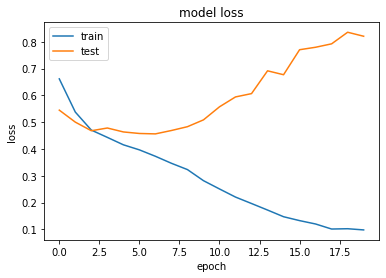

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show();

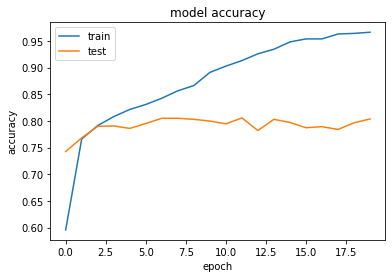

In [33]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show();

In [34]:
pred = model.predict(x_test, verbose=0)
y_pred = [1 if each > 0.5 else 0 for each in pred]

score, test_accuracy = model.evaluate(x_test, y_test)

print("Test Accuracy: ", test_accuracy)
print(classification_report(list(y_test), y_pred))

48/48 [==============================] - 4s 89ms/step - loss: 0.8210 - acc: 0.8037
Test Accuracy:  0.803676962852478
              precision    recall  f1-score   support

           0       0.78      0.92      0.84       886
           1       0.85      0.64      0.73       637

    accuracy                           0.80      1523
   macro avg       0.82      0.78      0.79      1523
weighted avg       0.81      0.80      0.80      1523



In [35]:
# holdout = df_test['clean_text']
# holdout = pad_sequences(tokenizer.texts_to_sequences(holdout), maxlen=sequence_len)

# holdout_preds = model.predict(holdout, verbose=0)
# preds1 = [1 if each > 0.5 else 0 for each in holdout_preds]

# id = df_test['id']
# submission1 = pd.DataFrame({"id": id, "target": preds1})
# submission1.to_csv("./drive/MyDrive/Colab Notebooks/MSDS422/disastertweets_submission_1.csv", index = False)

##### Model 2 - word2vec Bidirectional GRU

In [36]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(df_train['clean_text'],
                                                                   df_train['target'],
                                                                   test_size=0.2,
                                                                   random_state=0, 
                                                                   shuffle=True)

In [50]:
x_train2 = pad_sequences(tokenizer.texts_to_sequences(x_train2), maxlen=sequence_len)
x_test2 = pad_sequences(tokenizer.texts_to_sequences(x_test2), maxlen=sequence_len)

In [41]:
def load_word2vec():
    """ Load Word2Vec Vectors
        Return:
            wv_from_bin: All 3 million embeddings, each lengh 300
    """
    import gensim.downloader as api
    wv_from_bin = api.load("word2vec-google-news-300") # load 300-dimension word vectors
    vocab = list(wv_from_bin.vocab.keys())
    print("Loaded vocab size %i" % len(vocab))
    return wv_from_bin

In [42]:
def get_embedding(word_index):
    
  # create a matrix for the vocabulary of our training set, the row represents each vocabulary,
  # the column represents each dimention we created for this vocabulary
  embedding = np.zeros((len(word_index)+1, 300))
  for word in word_index.keys():
      if word in wv_from_bin.vocab.keys():
          embedding[word_index[word], :] = np.array(wv_from_bin.word_vec(word))
      else:
          embedding[word_index[word], :] = np.random.randn(300)
  return embedding

In [43]:
def get_maxlength(data):
  # vectorize the text
  tokenizer_obj = Tokenizer()
  tokenizer_obj.fit_on_texts(data)
  sequences = tokenizer_obj.texts_to_sequences(data)

  # find the max lengh of each sequence
  find_max=[]
  for i in range(len(sequences)):
      find_max.append(len(sequences[i]))
  max_length = max(find_max)
  return max_length

In [44]:
max_len = get_maxlength(df_train['clean_text'])

In [45]:
wv_from_bin = load_word2vec()

[==================================================] 100.0% 1662.8/1662.8MB downloaded
Loaded vocab size 3000000


In [46]:
wv_embedding = get_embedding(word_index)

In [48]:
embedding_dim = 300
Embedding_layer = Embedding((len(word_index)+1), embedding_dim,
                    embeddings_initializer=Constant(wv_embedding),
                    input_length=sequence_len,
                    trainable = False)

In [49]:
model2=Sequential()
model2.add(Embedding_layer)
model2.add(Bidirectional(GRU(32,dropout=0.2,recurrent_dropout=0.1,return_sequences=True)))
model2.add(Bidirectional(GRU(32,dropout=0.2,recurrent_dropout=0.1)))
model2.add(Dense(1,activation='sigmoid'))
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          4412400   
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 64)          64128     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               18816     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,495,409
Trainable params: 83,009
Non-trainable params: 4,412,400
_________________________________________________________________


In [52]:
history2 = model2.fit(x_train2, y_train2, 
          batch_size=128,
          epochs=epochs,
          verbose=2, 
          validation_data=(x_test2, y_test2))


Epoch 1/20
48/48 - 73s - loss: 0.4275 - acc: 0.8118 - val_loss: 0.4657 - val_acc: 0.7853 - 73s/epoch - 2s/step
Epoch 2/20
48/48 - 75s - loss: 0.4065 - acc: 0.8233 - val_loss: 0.4670 - val_acc: 0.7905 - 75s/epoch - 2s/step
Epoch 3/20
48/48 - 55s - loss: 0.3766 - acc: 0.8427 - val_loss: 0.4646 - val_acc: 0.7873 - 55s/epoch - 1s/step
Epoch 4/20
48/48 - 44s - loss: 0.3537 - acc: 0.8560 - val_loss: 0.4698 - val_acc: 0.7892 - 44s/epoch - 919ms/step
Epoch 5/20
48/48 - 44s - loss: 0.3390 - acc: 0.8606 - val_loss: 0.4817 - val_acc: 0.7807 - 44s/epoch - 915ms/step
Epoch 6/20
48/48 - 43s - loss: 0.3141 - acc: 0.8741 - val_loss: 0.4936 - val_acc: 0.7905 - 43s/epoch - 892ms/step
Epoch 7/20
48/48 - 44s - loss: 0.2976 - acc: 0.8823 - val_loss: 0.5088 - val_acc: 0.7866 - 44s/epoch - 917ms/step
Epoch 8/20
48/48 - 43s - loss: 0.2854 - acc: 0.8911 - val_loss: 0.5080 - val_acc: 0.7919 - 43s/epoch - 894ms/step
Epoch 9/20
48/48 - 43s - loss: 0.2698 - acc: 0.8969 - val_loss: 0.5290 - val_acc: 0.7879 - 43s/ep

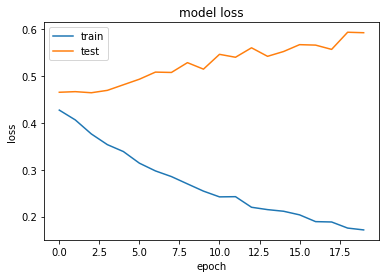

In [53]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show();

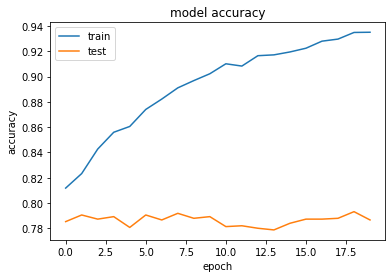

In [54]:
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show();

In [55]:
pred2 = model2.predict(x_test2, verbose=0)
y_pred2 = [1 if each > 0.5 else 0 for each in pred2]

score2, test_accuracy2 = model2.evaluate(x_test2, y_test2)

print("Test Accuracy: ", test_accuracy2)
print(classification_report(list(y_test2), y_pred2))

48/48 [==============================] - 3s 55ms/step - loss: 0.5930 - acc: 0.7866
Test Accuracy:  0.7866053581237793
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       886
           1       0.78      0.69      0.73       637

    accuracy                           0.79      1523
   macro avg       0.78      0.77      0.78      1523
weighted avg       0.79      0.79      0.78      1523



In [57]:
# holdout = df_test['clean_text']
# holdout = pad_sequences(tokenizer.texts_to_sequences(holdout), maxlen=sequence_len)

# holdout_preds2 = model2.predict(holdout, verbose=0)
# preds2 = [1 if each > 0.5 else 0 for each in holdout_preds2]

# id = df_test['id']
# submission2 = pd.DataFrame({"id": id, "target": preds2})
# submission2.to_csv("./drive/MyDrive/Colab Notebooks/MSDS422/disastertweets_submission_2.csv", index = False)

##### Model 3 - word2vec Bidirectional LSTM

In [60]:
model3=Sequential()
model3.add(Embedding_layer)
model3.add(Dropout(0.2))
model3.add(Bidirectional(LSTM(256)))
model3.add(Dropout(0.2))
model3.add(Dense(512, activation='relu'))
model3.add(Dropout(0.5))
model3.add(BatchNormalization())
model3.add(Dense(1,activation='sigmoid'))
model3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [61]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          4412400   
                                                                 
 dropout_4 (Dropout)         (None, 100, 300)          0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 512)              1140736   
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                      

In [62]:
history3 = model3.fit(x_train2, y_train2, 
          batch_size=128,
          epochs=epochs,
          verbose=2, 
          validation_data=(x_test2, y_test2))

Epoch 1/20
48/48 - 152s - loss: 0.6564 - accuracy: 0.6895 - val_loss: 0.6043 - val_accuracy: 0.7019 - 152s/epoch - 3s/step
Epoch 2/20
48/48 - 103s - loss: 0.4851 - accuracy: 0.7824 - val_loss: 0.5945 - val_accuracy: 0.7617 - 103s/epoch - 2s/step
Epoch 3/20
48/48 - 95s - loss: 0.4343 - accuracy: 0.8039 - val_loss: 0.5727 - val_accuracy: 0.7669 - 95s/epoch - 2s/step
Epoch 4/20
48/48 - 96s - loss: 0.3993 - accuracy: 0.8271 - val_loss: 0.5277 - val_accuracy: 0.7905 - 96s/epoch - 2s/step
Epoch 5/20
48/48 - 99s - loss: 0.3580 - accuracy: 0.8448 - val_loss: 0.5290 - val_accuracy: 0.7820 - 99s/epoch - 2s/step
Epoch 6/20
48/48 - 95s - loss: 0.3157 - accuracy: 0.8657 - val_loss: 0.5014 - val_accuracy: 0.7794 - 95s/epoch - 2s/step
Epoch 7/20
48/48 - 95s - loss: 0.3053 - accuracy: 0.8709 - val_loss: 0.5096 - val_accuracy: 0.7544 - 95s/epoch - 2s/step
Epoch 8/20
48/48 - 95s - loss: 0.2777 - accuracy: 0.8847 - val_loss: 0.4926 - val_accuracy: 0.7708 - 95s/epoch - 2s/step
Epoch 9/20
48/48 - 95s - los

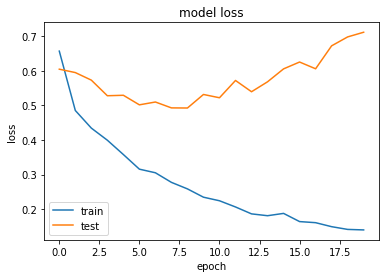

In [63]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show();

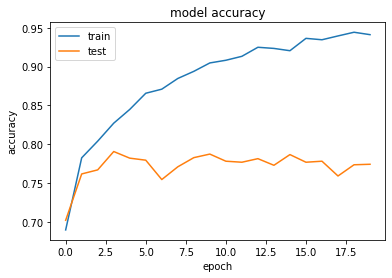

In [65]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show();

In [67]:
pred3 = model3.predict(x_test2, verbose=0)
y_pred3 = [1 if each > 0.5 else 0 for each in pred3]

score3, test_accuracy3 = model3.evaluate(x_test2, y_test2)

print("Test Accuracy: ", test_accuracy3)
print(classification_report(list(y_test2), y_pred2))

48/48 [==============================] - 11s 235ms/step - loss: 0.7109 - accuracy: 0.7741
Test Accuracy:  0.7741299867630005
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       886
           1       0.78      0.69      0.73       637

    accuracy                           0.79      1523
   macro avg       0.78      0.77      0.78      1523
weighted avg       0.79      0.79      0.78      1523



In [68]:
# holdout = df_test['clean_text']
# holdout = pad_sequences(tokenizer.texts_to_sequences(holdout), maxlen=sequence_len)

# holdout_preds3 = model3.predict(holdout, verbose=0)
# preds3 = [1 if each > 0.5 else 0 for each in holdout_preds3]

# id = df_test['id']
# submission3 = pd.DataFrame({"id": id, "target": preds3})
# submission3.to_csv("./drive/MyDrive/Colab Notebooks/MSDS422/disastertweets_submission_3.csv", index = False)

It doesn't seem like any of the three models are breaking 80% on the validation accuracy as well as the Kaggle score. My thinking is that it may need additional data preprocessing that would allow the embeddings and models to be more effective at differentiating disaster tweets. Another thing that could potentially be used is the keyword field in the dataset which is not currently in use. From what I saw, it didn't seem like the location provided any useful information given certain records did not even include a "real" location. In future iterations of this project, additional preprocessing and the keyword dimension should be revisited. 